In [7]:
!pip install prophet

   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
    --------------------------------------- 0.3/13.3 MB 8.3 MB/s eta 0:00:02
   --- ------------------------------------ 1.0/13.3 MB 13.3 MB/s eta 0:00:01
   --- ------------------------------------ 1.0/13.3 MB 13.3 MB/s eta 0:00:01
   --- ------------------------------------ 1.0/13.3 MB 13.3 MB/s eta 0:00:01
   --- ------------------------------------ 1.0/13.3 MB 13.3 MB/s eta 0:00:01
   ---- ----------------------------------- 1.4/13.3 MB 4.8 MB/s eta 0:00:03
   ------ --------------------------------- 2.2/13.3 MB 7.2 MB/s eta 0:00:02
   ---------- ----------------------------- 3.6/13.3 MB 9.6 MB/s eta 0:00:02
   --------------- ------------------------ 5.0/13.3 MB 11.5 MB/s eta 0:00:01
   ----------------- ---------------------- 5.8/13.3 MB 12.4 MB/s eta 0:00:01
   ------------------------ --------------- 8.2/13.3 MB 15.4 MB/s eta 0:00:01
   -------------------------- ------------- 8.8/13.3 MB 15.6 MB/s eta 0:00:0

In [108]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [80]:
from prophet import Prophet
import pandas as pd

data = pd.read_csv('cleaned_data.csv')
data.head()

C:\Users\cmanh\AppData\Local\Temp\ipykernel_15204\939403889.py:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('cleaned_data.csv')


,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [81]:
data['Sales amount']=data['Quantity']*data['UnitPrice']
data.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales amount
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


In [82]:
from datetime import datetime
import datetime as dt

data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Aggregate data by InvoiceNo
aggregated_data = data.groupby('InvoiceNo').agg({          
    'Sales amount': 'sum',           
    'InvoiceDate': 'last'            
}).reset_index()

aggregated_data.head()


,InvoiceNo,Sales amount,InvoiceDate
0,536365,139.12,2010-12-01 08:26:00
1,536366,22.20,2010-12-01 08:28:00
2,536367,278.73,2010-12-01 08:34:00
3,536368,70.05,2010-12-01 08:34:00
4,536369,17.85,2010-12-01 08:35:00


In [84]:
Q1 = aggregated_data['Sales amount'].quantile(0.25)
Q3 = aggregated_data['Sales amount'].quantile(0.75)
IQR = Q3 - Q1

# Defining the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtering the DataFrame to remove outliers
aggregated_data = aggregated_data[(aggregated_data['Sales amount'] >= lower_bound) & (aggregated_data['Sales amount'] <= upper_bound)]

## Train/Test split

In [60]:
aggregated_data.head()

,InvoiceNo,Sales amount,InvoiceDate,date,hour,dayofweek,weekday,quarter,month,year,dayofyear,dayofmonth,date_offset,season
0,536365,139.12,2010-12-01 08:26:00,2010-12-01 08:26:00,8,2,Wednesday,4,12,2010,335,1,881,Fall
1,536366,22.20,2010-12-01 08:28:00,2010-12-01 08:28:00,8,2,Wednesday,4,12,2010,335,1,881,Fall
2,536367,278.73,2010-12-01 08:34:00,2010-12-01 08:34:00,8,2,Wednesday,4,12,2010,335,1,881,Fall
3,536368,70.05,2010-12-01 08:34:00,2010-12-01 08:34:00,8,2,Wednesday,4,12,2010,335,1,881,Fall
4,536369,17.85,2010-12-01 08:35:00,2010-12-01 08:35:00,8,2,Wednesday,4,12,2010,335,1,881,Fall


In [86]:
extracted_columns = aggregated_data[['InvoiceDate', 'Sales amount']]
extracted_columns.head()

,InvoiceDate,Sales amount
0,2010-12-01 08:26:00,139.12
1,2010-12-01 08:28:00,22.20
2,2010-12-01 08:34:00,278.73
3,2010-12-01 08:34:00,70.05
4,2010-12-01 08:35:00,17.85


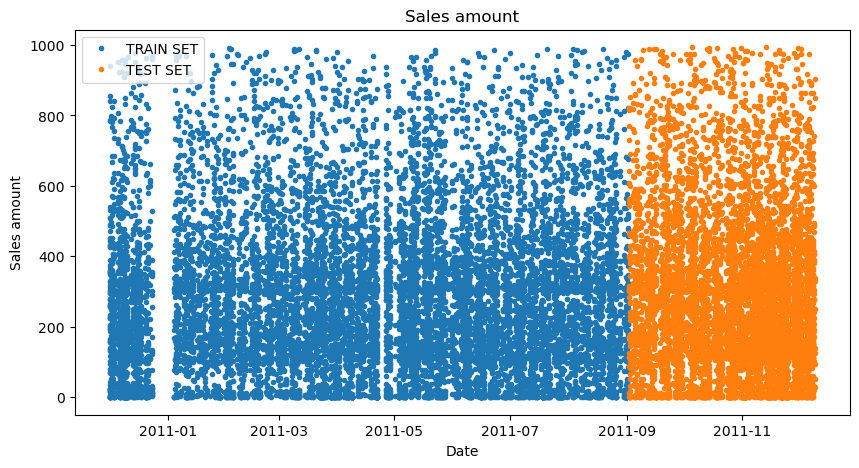

In [87]:
# Split date
split_date = pd.to_datetime('2011-09-02')

# Split the data into train and test sets
data_train = extracted_columns.loc[extracted_columns['InvoiceDate'] <= split_date].copy()
data_test = extracted_columns.loc[extracted_columns['InvoiceDate'] > split_date].copy()

# Plot train and test sets to visualize the split
plt.figure(figsize=(10, 5))
plt.plot(data_train['InvoiceDate'], data_train['Sales amount'], '.', label='TRAIN SET')
plt.plot(data_test['InvoiceDate'], data_test['Sales amount'], '.', label='TEST SET')
plt.title('Sales amount')
plt.xlabel('Date')
plt.ylabel('Sales amount')
plt.legend()
plt.show()

In [88]:
# Format data for prophet model using ds and y
data_train_prophet = data_train.reset_index() \
    .rename(columns={'InvoiceDate':'ds',
                     'Sales amount':'y'})

In [89]:
%%time
model = Prophet()
model.fit(data_train_prophet)

04:57:15 - cmdstanpy - INFO - Chain [1] start processing
04:57:17 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 625 ms
Wall time: 2.57 s


In [90]:
# Predict on test set with model
data_test_prophet = data_test.reset_index() \
    .rename(columns={'InvoiceDate':'ds',
                     'Sales amount':'y'})

data_test_fcst = model.predict(data_test_prophet)

In [91]:
data_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-09-02 08:50:00,235.178459,49.862386,617.995182,235.178459,235.178459,100.637153,100.637153,100.637153,67.760015,67.760015,67.760015,32.877138,32.877138,32.877138,0.0,0.0,0.0,335.815612
1,2011-09-02 09:43:00,235.178017,53.406266,618.569329,235.178017,235.178017,99.736653,99.736653,99.736653,70.480230,70.480230,70.480230,29.256423,29.256423,29.256423,0.0,0.0,0.0,334.914670
2,2011-09-02 09:45:00,235.178000,70.991194,611.087360,235.178000,235.178000,99.482924,99.482924,99.482924,70.370954,70.370954,70.370954,29.111970,29.111970,29.111970,0.0,0.0,0.0,334.660924
3,2011-09-02 09:48:00,235.177975,49.918455,639.527273,235.177975,235.177975,99.073017,99.073017,99.073017,70.178779,70.178779,70.178779,28.894238,28.894238,28.894238,0.0,0.0,0.0,334.250992
4,2011-09-02 09:51:00,235.177950,49.677951,621.397683,235.177950,235.177950,98.628493,98.628493,98.628493,69.953245,69.953245,69.953245,28.675248,28.675248,28.675248,0.0,0.0,0.0,333.806443


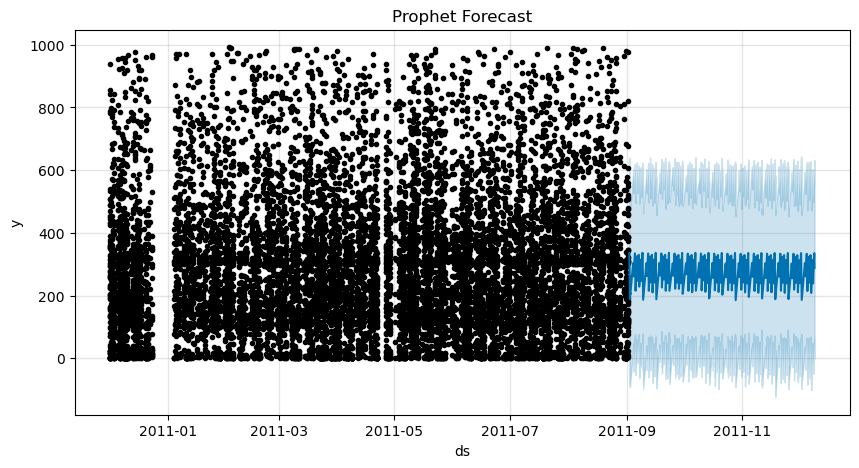

In [92]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(data_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

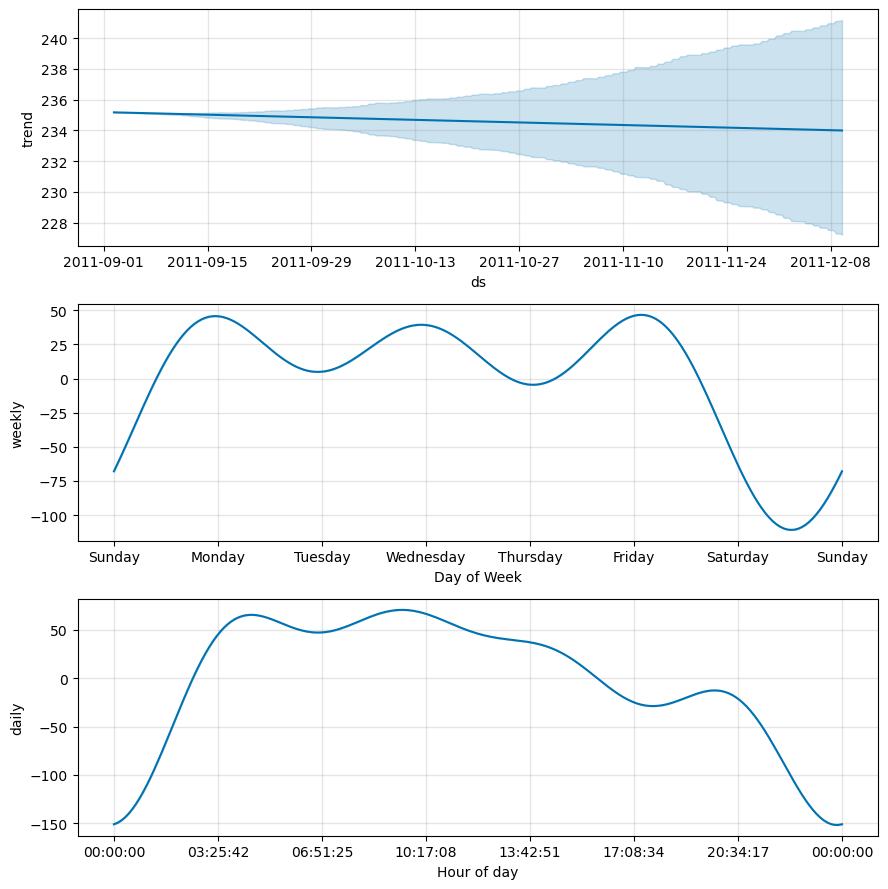

In [93]:
fig = model.plot_components(data_test_fcst)
plt.show()

## Benchmark with Actual sales 

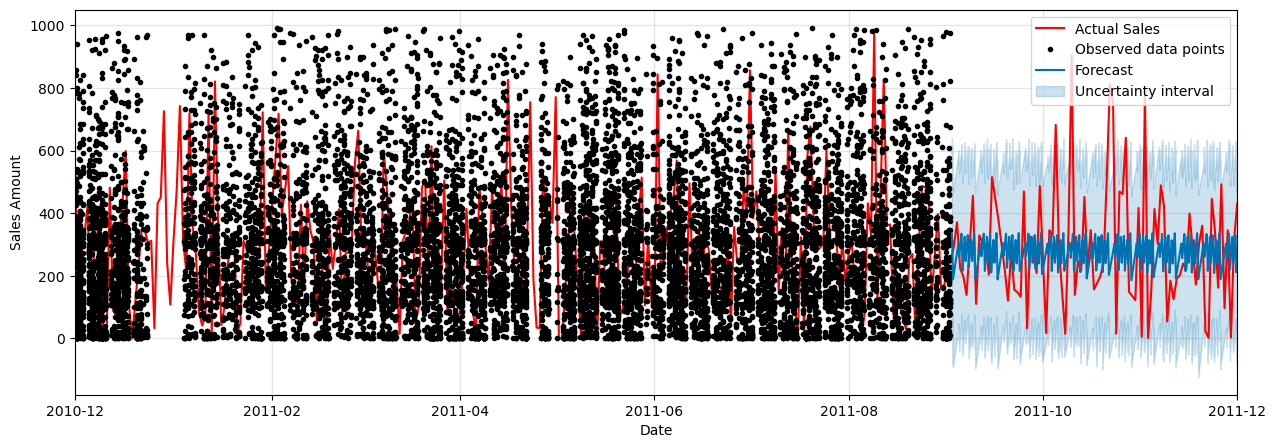

In [105]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.plot(data_test.index, data_test['Sales amount'], color='r', label='Actual Sales')
fig = model.plot(data_test_fcst, ax=ax)
start_date = datetime(2010, 12, 1)
end_date = datetime(2011, 12, 1)
ax.set_xlim([start_date, end_date])
ax.set_xlabel('Date')
ax.set_ylabel('Sales Amount')
ax.legend()

plt.show()

## Evaluate the model with Error Metrics 

In [109]:
import numpy as np
np.sqrt(mean_squared_error(y_true=data_test['Sales amount'],
                   y_pred=data_test_fcst['yhat']))

222.29408529031784

In [110]:
mean_absolute_error(y_true=data_test['Sales amount'],
                   y_pred=data_test_fcst['yhat'])

172.85966959799833

In [112]:
mean_absolute_percentage_error(y_true=data_test['Sales amount'],
                   y_pred=data_test_fcst['yhat'])

inf